In [1]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
torch.set_default_dtype(torch.float64)

In [2]:
dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]

In [3]:
model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

In [4]:
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

In [5]:
# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

In [6]:
# interior
sampling_mode = 'random' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

In [7]:
# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

In [8]:
steps = 20
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))
    
    

In [9]:
train()

pde loss: 5.43e+00 | bc loss: 6.83e-02 | l2: 2.41e-02 : 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


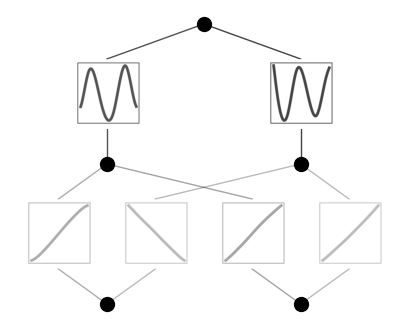

In [10]:
model.plot()

In [11]:
for i in range(2):
    for j in range(2):
        model.fix_symbolic(0,i,j,'x')
        
for i in range(2):
    model.fix_symbolic(1,i,0,'sin')

Best value at boundary.
r2 is 0.9975286545980323
Best value at boundary.
r2 is 0.9997013456799192
Best value at boundary.
r2 is 0.9988938638390205
Best value at boundary.
r2 is 0.9985526450810092
r2 is 0.9914903307381042
r2 is 0.9897447076451878


In [12]:
train()

pde loss: 6.81e-17 | bc loss: 1.10e-18 | l2: 2.16e-19 : 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


In [13]:
formula = model.symbolic_formula(floating_digit=5)[0][0]
formula

-0.5*sin(-3.14159*x_1 + 3.14159*x_2 + 4.71239) - 0.5*sin(3.14159*x_1 + 3.14159*x_2 + 7.85398)

/Users/lihaoyang/anaconda3/envs/pykan/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


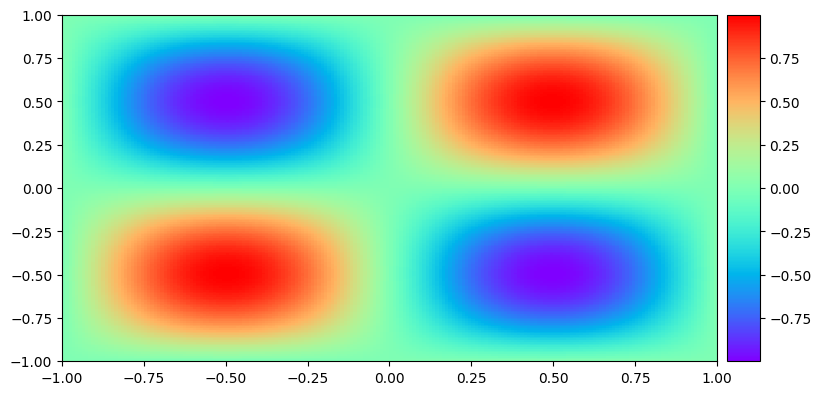

In [14]:
def plot_true():
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        usol = sol_fun(x_i)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./2D_poisson_true.png')
        plt.show()

plot_true()